# 텐서플로 허브와 전이학습

텐서플로 허브는 이 전에 학습된 모델들의 요소들을 공유하는 하나의 방법입니다.</br>
학습된 모델들의 검색 가능한 리스트에 대한 텐서플로 모듈 허브를 보세요. 


1.   tf.keras 로 텐서플로 허브를 사용하는 방법
2.   텐서플로 허브를 사용하여 이미지 분류를 하는 방법
3.   간단한 전이학습을 하는 방법



## 설치하기

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf

In [2]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

     |████████████████████████████████| 109 kB 5.0 MB/s 


## ImageNet 분류기

### 분류기 다운로드하기
이동 네트워크 컴퓨터를 로드하기 위해 hub.module 을, 그리고 하나의 keras층으로 감싸기 위해</br>
tf.keras.layers.Lambda 를 사용하세요.</br>
Fthub.dev의 텐서플로2.0 버전의 양립 가능한 이미지 분류기 URL 은 이곳에서 작동할 것입니다.

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### 싱글 이미지 실행시키기
모델을 시도하기 위해 싱글 이미지를 다운로드하세요.

65536/61306 [================================] - 0s 0us/step


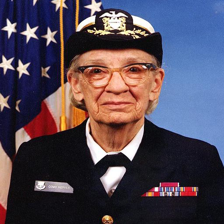

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

차원 배치를 추가하세요. 그리고 이미지를 모델에 통과시키세요.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

그 결과는 로지트의 1001 요소 벡터입니다. 이는 이미지에 대한 각각의 클래스 확률을 계산합니다.
</br>
그래서 탑 클래스인 ID는 최대값을 알 수 있습니다.


In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### 예측 해독하기
우리는 클래스 ID를 예측하고, ImageNet라벨을 불러오고, 그리고 예측을 해독합니다.

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


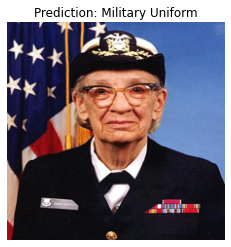

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 간단한 전이 학습
텐서플로 허브를 사용함으로써, 우리의 데이터셋에 있는 클래스들을 인지하기 위해 모델의 최상위 층을 재학습 시키는 것이 쉬워졌습니다.

### 데이터셋
이 예제를 해결하기 위해, 텐서플로의 flowers 데이터셋을 사용할 것입니다.

In [12]:
data_root = tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      untar=True)

228818944/228813984 [==============================] - 2s 0us/step


우리의 모델에 이 데이터를 가장 간단하게 로딩 하는 방법은</br>
tf.keras.preprocessing.image.image.ImageDataGenerator 를 사용하는 것 이고,
</br></br>
모든 텐서플로 허브의 이미지 모듈들은 0과 1 사이의 상수들의 입력을 기대합니다.</br>
이를 만족 시키기 위해 ImageDataGenerator 의 rascale 인지를 사용하세요.
</br></br>
그 이미지의 사이즈는 나중에 다뤄질 것입니다.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


결과로 나온 오브젝트는 iamge_batch 와 label_batch를 같이 리턴하는 반복자입니다.

In [14]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### 이미지 배치에 대한 분류기
이제 이미지 배치에 대한 분류기를 실행해봅시다.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'mushroom', 'bee', 'cucumber', 'daisy', 'candle',
       'daisy', 'cardoon', 'bee', 'daisy', 'daisy', 'daisy', 'maze',
       'pot', 'velvet', 'vase', "jack-o'-lantern", 'sea urchin',
       'picket fence', 'park bench', 'daisy', 'daisy', 'wreck', 'vase',
       'sea urchin', 'daisy', 'bee', 'bee', 'vase', 'artichoke', 'daisy'],
      dtype='<U30')

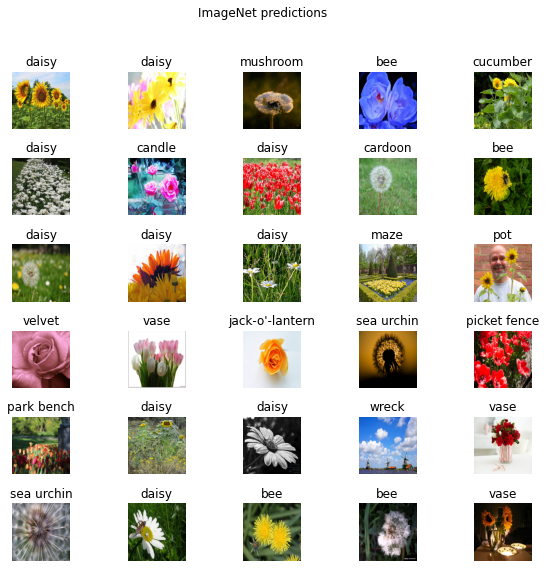

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

이미지 속성을 가진 LICENSE.txt 파일을 보세요.
</br></br>
결과가 완벽과는 거리가 멀지만, 모델이 ("daisy"를 제외한) 모든 것을 대비해서 학습된 클래스가 아니라는 것을 고려하면 합리적입니다.

### 헤드리스 모델 다운로드
텐서플로 허브는 맨 위 분류 층이 없어도 모델을 분배 시킬 수 있습니다.</br>
이는 전이 학습을 쉽게 할 수 있게 만들었습니다.
</br></br>
fthub.dev의 텐서플로 2.0버전의 양립가능한 이미지 특성 벡터 URL 은 모두 이 곳에서 작동할 것입니다.

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature 추출기를 만들어 봅시다.

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224, 224,3))

이 것은 각각의 이미지마다 길이가 1280인 벡터가 반환됩니다.

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면, 학습은 오직 새로운 분류 계층만 변경시킬 수 있습니다.

### 분류 head
이제 tf.keras.Sequential 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가하세요.

In [22]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

### 모델 학습
학습 과정 환경을 설정하기 위해 컴파일을 사용하세요.

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

이제 모델을 학습시키기 위해 .fit 방법을 사용하세요.
</br></br>
예제를 짧게 유지시키기 위해 오로지 2세대만 학습시키세요.</br>
학습 과정을 시각화하기 위해서, 맞춤형 회신을 사용하면 손실과, 세대 평균이 아닌 배치 개별의 정확도를 기록할 수 있습니다.

In [28]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [30]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
115/115 [==============================] - 106s 891ms/step - loss: 0.4263 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 101s 880ms/step - loss: 0.2549 - acc: 0.8636


지금부터, 단순한 학습 반복이지만, 우리는 항상 모델이 프로세스를 만드는 중이라는 것을 알 수 있습니다.

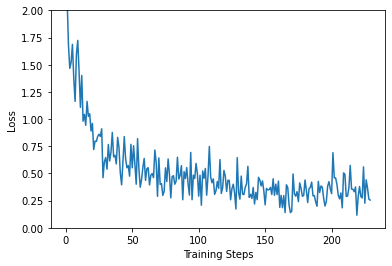

In [31]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

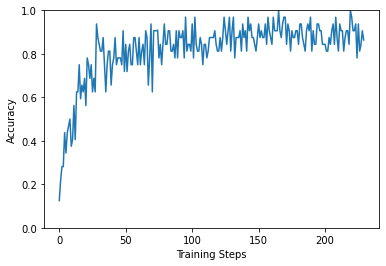

In [32]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### 예측 확인
이 전의 계획을 다시하기 위해서, 클래스이름들의 정렬된 리스트를 첫번째로 얻으세요.

In [33]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

모델을 통해 이미지 배치를 실행시키세요. 그리고 인덱스들을 클래스 이름을 바꾸세요.

In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

결과를 계획하세요.

In [35]:
label_id = np.argmax(label_batch, axis=-1)

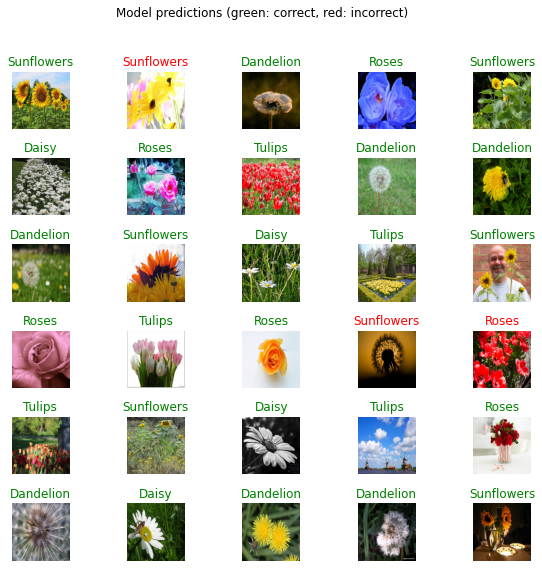

In [36]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## 모델 로드
저장된 모델을 로드하기

In [37]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1626767082/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1626767082/assets


'/tmp/saved_models/1626767082'

이제 그것을 새롭게 로딩 할 수 있고, 이는 같은 결과를 줄 것입니다:

In [38]:
reloaded = tf.keras.models.load_model(export_path)

In [39]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [42]:
abs(reloaded_result_batch - result_batch).max()

0.0